RFM 기법을 이용해서 고객을 군집화
<ul>
    <li>RECENCY(R): 가장 최근 상품 구입 일에서 오늘까지의 시간</li>
    <li>FREQUENCY(F): 상품 구매 횟수</li>
    <li>MONETARY(M): 총 구매 금액</li>
</ul>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
retail_df = pd.read_csv('./data/Online_Retail.csv', encoding='latin1')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
retail_df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceDate Datetime으로 형변환

In [5]:
date_format = "%m/%d/%y %H:%M"

In [6]:
retail_df['InvoiceDate'] = retail_df['InvoiceDate'].apply(lambda x : datetime.datetime.strptime(x, date_format))

1. Null 데이터 제거: 고객 식별 변호가 없는 데이터 삭제
2. 오류 데이터 삭제: Quantity 또는 UnitPrice가 0보다 작은 경우
3. CustomerID -> int형으로 형변환

In [7]:
retail_df = retail_df[(retail_df['Quantity']>0) & (retail_df['UnitPrice']>0) & (retail_df['CustomerID'].notnull())]

In [8]:
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [9]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int32         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.8+ MB


### RFM 기반 데이터 가공

주문 금액 = UnitPrice * Quantity

In [10]:
retail_df['OrderAmount'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [11]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [12]:
# 주문 수 상위 5명
retail_df['CustomerID'].value_counts().head(5)

17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: CustomerID, dtype: int64

In [13]:
# 금액 순 상위 5명
retail_df.groupby('CustomerID')['OrderAmount'].sum().sort_values(ascending=False).head(5)

CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
Name: OrderAmount, dtype: float64

고객 레벨로 세그멘테이션을 수행해야하기 떄문에 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 groupby

In [14]:
cust_df = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'OrderAmount': 'sum'
})

In [15]:
cust_df = cust_df.reset_index()

In [16]:
cust_df = cust_df.rename(columns ={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'OrderAmount':'Monetary'
})

In [17]:
cust_df

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24
3,12349,2011-11-21 09:51:00,73,1757.55
4,12350,2011-02-02 16:01:00,17,334.40
...,...,...,...,...
4333,18280,2011-03-07 09:52:00,10,180.60
4334,18281,2011-06-12 10:53:00,7,80.82
4335,18282,2011-12-02 11:43:00,12,178.05
4336,18283,2011-12-06 12:02:00,756,2094.88


In [18]:
# Recency 컬럼 값을 (오늘 날짜 - 최근 주문 날짜)로 변경

In [19]:
today = datetime.datetime.now()

In [20]:
recent_day = cust_df['Recency'].max()
recent_day

Timestamp('2011-12-09 12:50:00')

In [21]:
cust_df['Recency'] = today - cust_df['Recency']

In [22]:
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)

In [23]:
cust_df

,CustomerID,Recency,Frequency,Monetary
0,12346,4794,1,77183.60
1,12347,4471,182,4310.00
2,12348,4544,31,1797.24
3,12349,4487,73,1757.55
4,12350,4779,17,334.40
...,...,...,...,...
4333,18280,4746,10,180.60
4334,18281,4649,7,80.82
4335,18282,4476,12,178.05
4336,18283,4472,756,2094.88


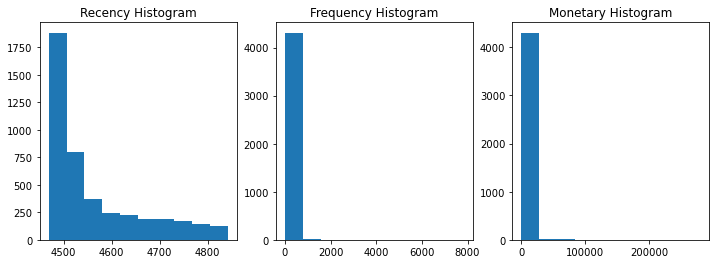

In [24]:
#hist()를 이용하여 각 칼럼의 값 분포도 확인
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

In [25]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,4561.039189,91.720609,2054.266460
std,100.009962,228.785094,8989.230441
min,4469.000000,1.000000,3.750000
25%,4486.000000,17.000000,307.415000
50%,4519.000000,41.000000,674.485000
75%,4610.750000,100.000000,1661.740000
max,4842.000000,7847.000000,280206.020000


<ul>
    <li>Recency는 평균이 92.7이지만, 50%인 51보다 크게 높음, max 는 374로 75%인 143보다 훨씬 커 왜곡 정도가 심함</li>
    <li>Frequency의 경우 평균이 90.3이지만 max 값 7847를 포함한 상위의 몇 개의 큰 값으로 인해 75%가 99.25에 가까움</li>
    <li>Monetary도 마찬가지로 상위의 큰 값으로 인해 평균은 1864.3으로 75%인 1576.5보다 높은 값이 확인 됨</li>
</ul>
->
StandardScaler로 평균과 표준편차를 재조정

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [27]:
X_features = cust_df[['Recency','Frequency', 'Monetary']]

In [28]:
X_features

,Recency,Frequency,Monetary
0,4794,1,77183.60
1,4471,182,4310.00
2,4544,31,1797.24
3,4487,73,1757.55
4,4779,17,334.40
...,...,...,...
4333,4746,10,180.60
4334,4649,7,80.82
4335,4476,12,178.05
4336,4472,756,2094.88


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features_scaled = StandardScaler().fit_transform(X_features.values)

In [30]:
# 로그 변환
cust_df['Recency_log'] = np.log1p(cust_df["Recency"])
cust_df['Frequency_log'] = np.log1p(cust_df["Frequency"])
cust_df['Monetary_log'] = np.log1p(cust_df["Monetary"])

In [31]:
X_features_log = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_log_scaled = StandardScaler().fit_transform(X_features_log)

In [32]:
# K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print(f'silhouette_score : {silhouette_score(X_features_scaled, labels):.3f}')

silhouette_score : 0.602


In [38]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

In [39]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

C:\Users\sella\Anaconda3\envs\Recsys\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
C:\Users\sella\Anaconda3\envs\Recsys\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


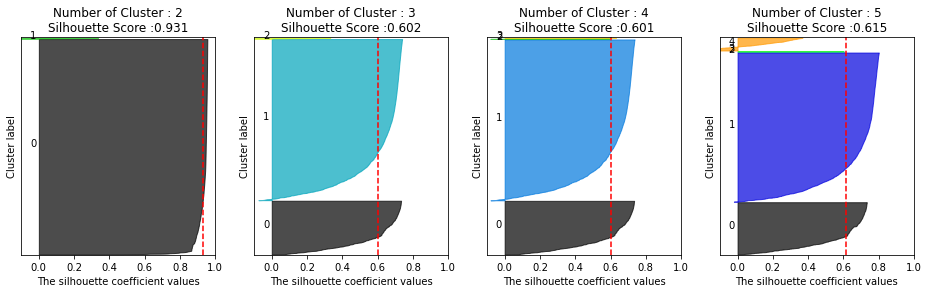

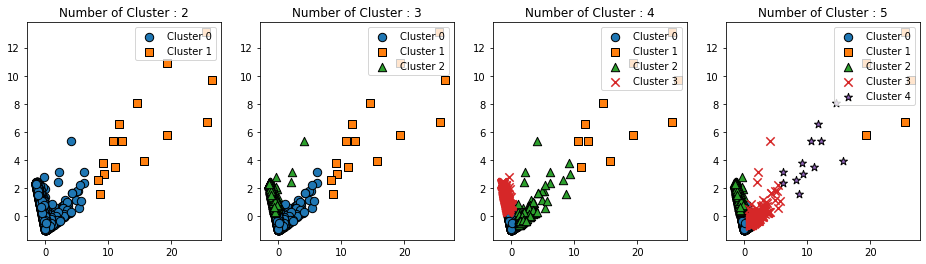

In [40]:
# 각 군집별 실루엣 계수 값 확인을 위해 군집 개수를 2~5개까지 변화시켜가며 군집화 구성 시각화
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

C:\Users\sella\Anaconda3\envs\Recsys\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
C:\Users\sella\Anaconda3\envs\Recsys\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


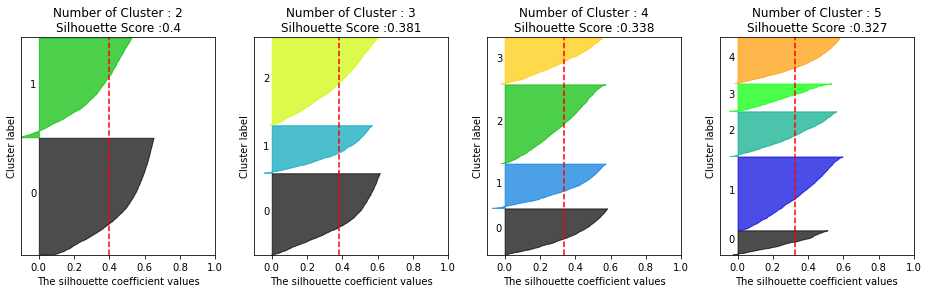

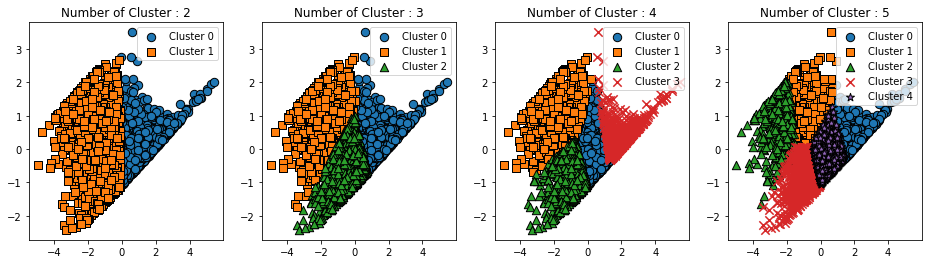

In [41]:
visualize_silhouette([2,3,4,5], X_features_log_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_log_scaled)

In [ ]:
# DBSCAN

In [42]:
from sklearn.decomposition import PCA
import pandas as df

In [43]:
X_features_scaled.shape[0]

4338

In [122]:
core_samples_indices = dbscan.core_sample_indices_
is_core_samples = [1 if i in core_samples_indices else 0 for i in range(X_features_scaled.shape[0])]

# 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_features_scaled)
dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

In [123]:
dbscan = DBSCAN(eps=0.8, min_samples=10).fit(X_features_scaled)

dbscan_pca_transformed = DBSCAN(eps=1, min_samples=5).fit_predict(pca_transformed)
dataframe['cluster'] = dbscan_pca_transformed

In [124]:
unique_labels = np.unique(dbscan_pca_transformed)
unique_labels

array([-1,  0,  1], dtype=int64)

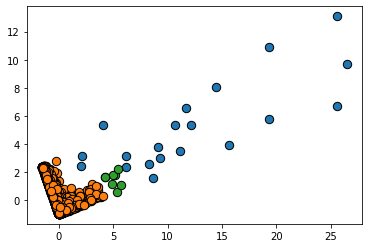

In [125]:
fig = plt.figure()
ax = fig.add_subplot()

for label in unique_labels:
    label_df = dataframe[dataframe['cluster']==label]
    if label == -1:
        cluster_legend = 'Noise'
    else :
        cluster_legend = 'Cluster '+str(label)           
    ax.scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,edgecolor='k')
    
plt.show()

In [126]:
print(f'silhouette_score : {silhouette_score(X_features_log_scaled, dbscan_pca_transformed):.3f}')

silhouette_score : 0.419


로그 스케일 후

In [127]:
# 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_features_log_scaled)
dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

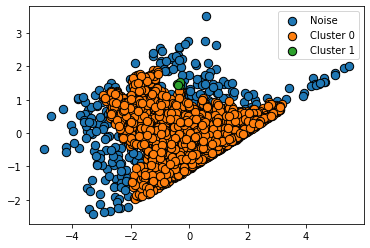

In [141]:
dbscan_pca_transformed = DBSCAN(eps=0.1, min_samples=3).fit_predict(pca_transformed)
dataframe['cluster'] = dbscan_pca_transformed

fig = plt.figure()
ax = fig.add_subplot()

for label in unique_labels:
    label_df = dataframe[dataframe['cluster']==label]
    if label == -1:
        cluster_legend = 'Noise'
    else :
        cluster_legend = 'Cluster '+str(label)           
    ax.scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,edgecolor='k', label=cluster_legend)

ax.legend(loc='upper right')
plt.show()

In [132]:
print(f'silhouette_score : {silhouette_score(X_features_log_scaled, dbscan_pca_transformed):.3f}')

silhouette_score : 0.441
